In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_std_cluster_atmos
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle

Importo il dizionario models come file

In [2]:
# Caricamento del dizionario
with open('models.pkl', 'rb') as file:
    models = dill.load(file)

Importo lista e immagini in un file pickle di modelli_tos

In [3]:
#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0_pca = pickle.load(f)
    list_cluster1_pca = pickle.load(f)
    list_cluster2_pca = pickle.load(f)
    list_cluster3_pca = pickle.load(f)
    list_cluster4_pca = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    cluster_4_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)
    cluster_4_mean_pdf = pickle.load(f)

Dizionario e calcoli per atmos

In [4]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_atmos = {}

In [5]:
#Costruisco il dizionario models_atmos con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models_atmos = '/work/users/guest/sbeltrami/prova/name_atmos_model.txt'
path_models_atmos = '/work/users/guest/sbeltrami/prova/path_atmos_model.txt'
path_remap_models_atmos = '/work/users/guest/sbeltrami/prova/path_remap_atmos_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_atmos, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_atmos = file.readlines()
with open(path_models_atmos, 'r') as file:
    lines_path_models_atmos = file.readlines()
with open(path_remap_models_atmos, 'r') as file:
    lines_path_remap_models_atmos = file.readlines()

In [6]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models_atmos, lines_path_models_atmos, lines_path_remap_models_atmos): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_atmos:
        models_atmos[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_atmos[model_name]['atmos name'] = model_name
    models_atmos[model_name]['atmos path'] = line_path.strip()
    models_atmos[model_name]['atmos path remap'] = line_path_remap.strip()
for name in models_atmos.keys():
    path_remap = models_atmos[name]['atmos path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_atmos[name]['atmos dataset'] = xr.open_dataset(path_remap)
        dataset = models_atmos[name]['atmos dataset']
        #peso il dataset
        models_atmos[name]['atmos dataset weighted'] = compute_dataset_weighted(dataset["ua"])
        #medie annuali con dataset pesato
        models_atmos[name]['atmos dataset annual mean'] = compute_annual_mean_weighted(models_atmos[name]['atmos dataset weighted'])
        print(models_atmos[name]['atmos name']) 

        #Seleziono il box del Nord Atlantico
        models_atmos[name]['atmos North Atlantic box'] = dataset.sel(lon=slice(280,360), lat=slice(20,80))
        na_box = models_atmos[name]['atmos North Atlantic box']
        #peso il dataset Nord Atlantico
        models_atmos[name]['atmos North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["ua"])
        #calcolo la media annuale del dataset Nord Atlantico
        models_atmos[name]['atmos North Atlantic annual mean weighted'] = compute_annual_mean_weighted(models_atmos[name]['atmos North Atlantic dataset weighted'])
        #Seleziono la climatologia
        na_box_climat = na_box.sel(time=slice("1982-01", "2014-12"))
        #peso il dataset del periodo scelto per la climatologia
        models_atmos[name]['atmos North Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["ua"])
        #calcolo la media annuale del dataset na sul periodo scelto
        models_atmos[name]['atmos North Atlantic annual mean climatology'] = compute_annual_mean_weighted(models_atmos[name]['atmos North Atlantic climatology weighted'])
        #Calcolo l'anomalia di ua rispetto alla climatologia scelta
        models_atmos[name]['atmos North Atlantic anomaly'] = compute_anomaly(models_atmos[name]['atmos North Atlantic annual mean weighted'],models_atmos[name]['atmos North Atlantic annual mean climatology'])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


In [7]:
#Creo una lista con il nome dei modelli
models_list_atmos = list(models_atmos.keys())

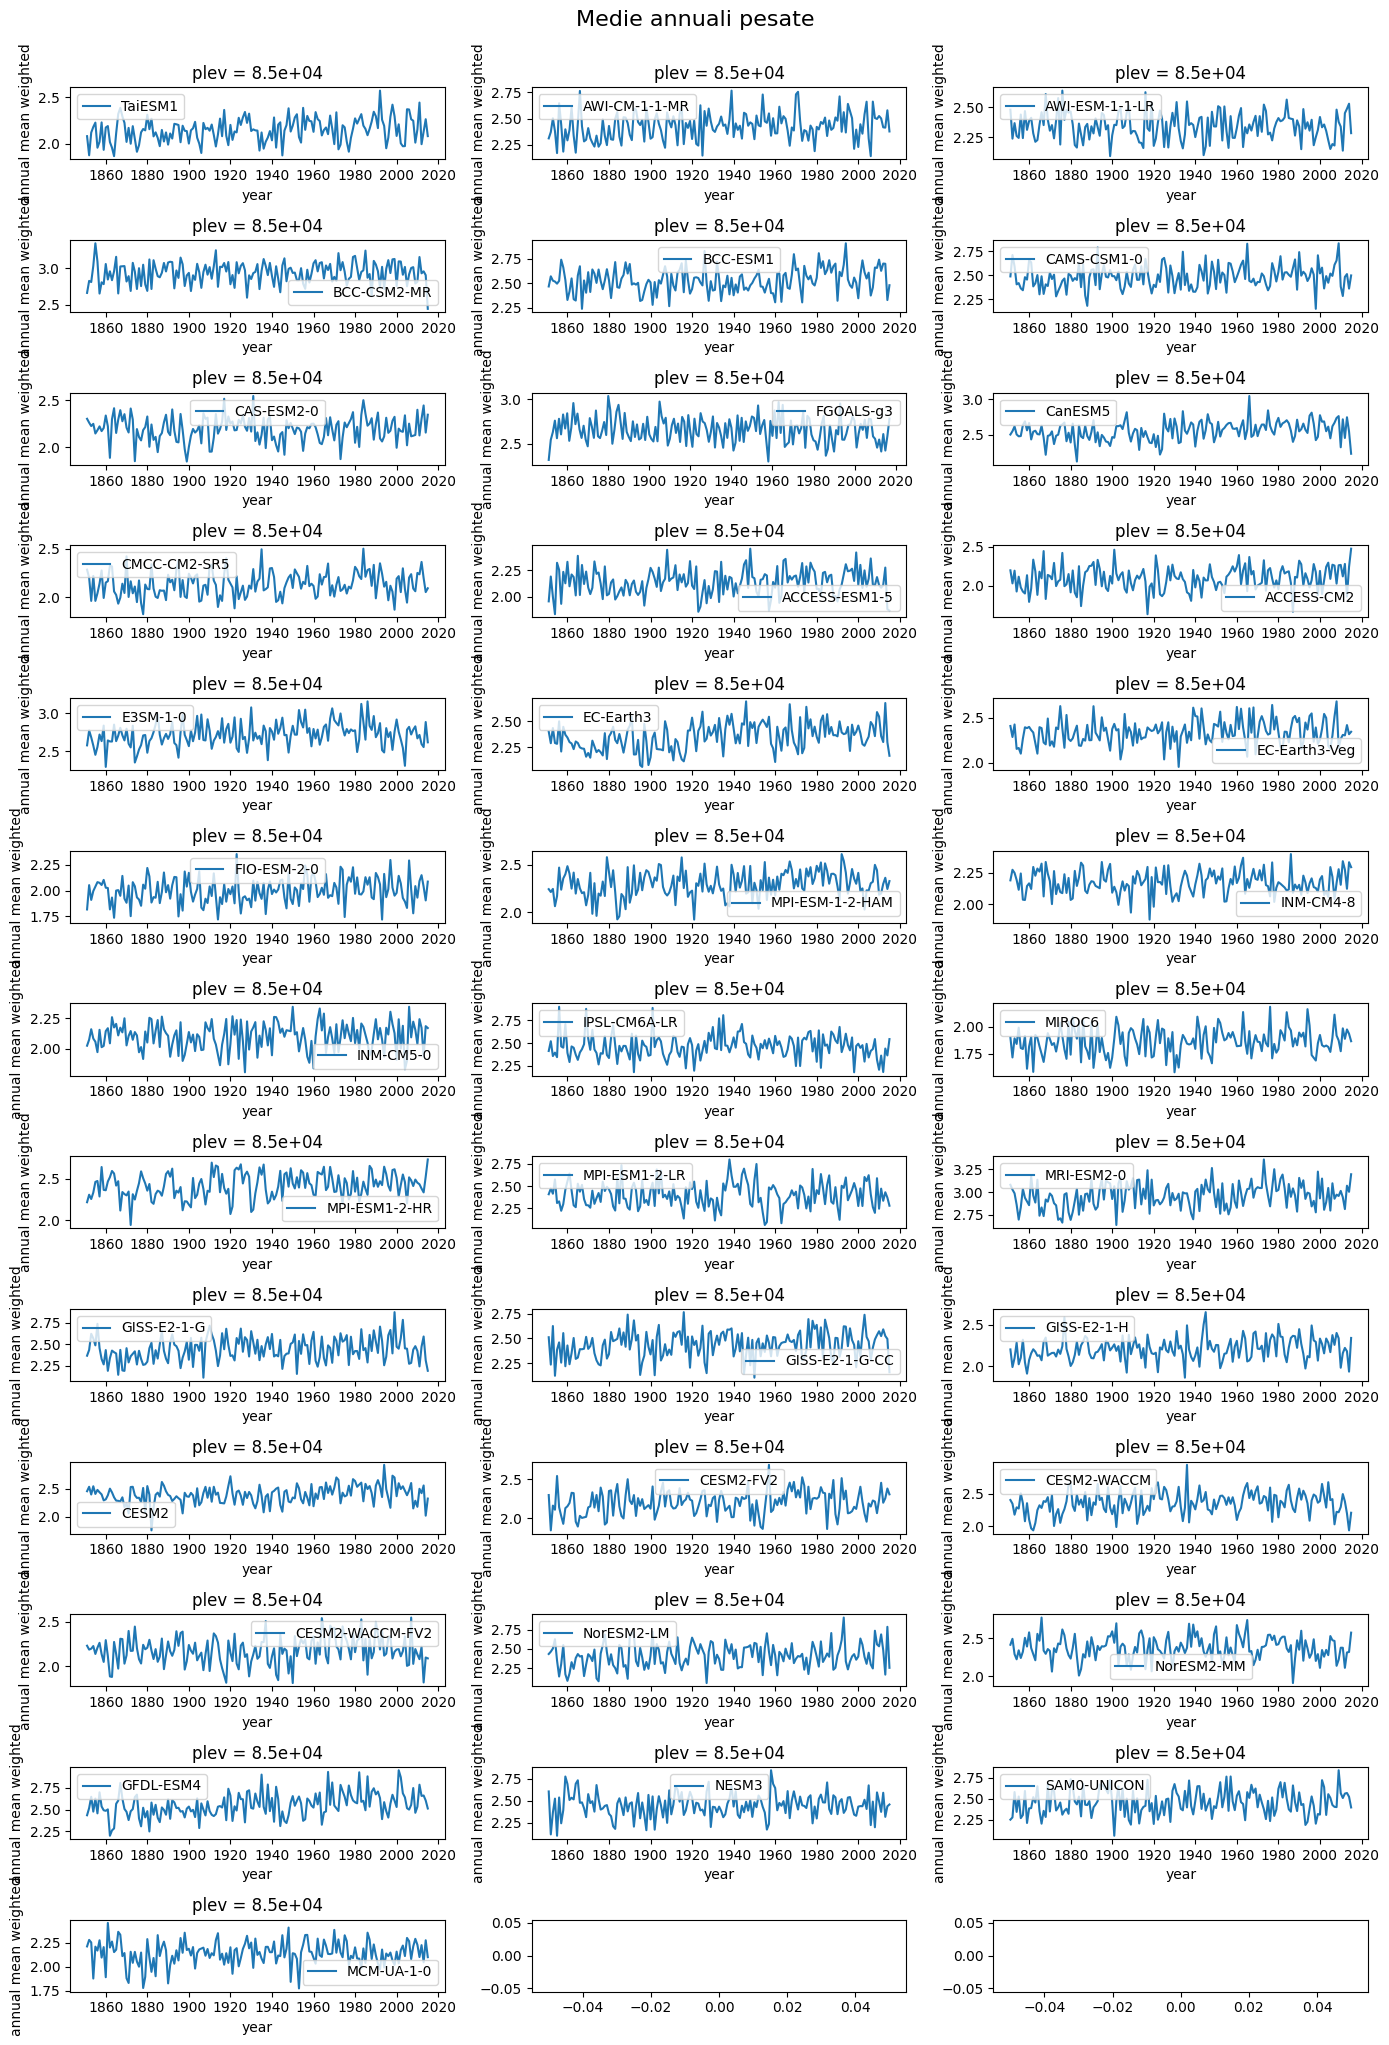

In [8]:
#plot medie annuali dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_atmos)/3)+1),ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range(int(len(models_atmos)/3)+1): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos):
            break
        model_name = models_list_atmos[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic annual mean weighted'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('annual mean weighted')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Medie annuali pesate', fontsize=16, y=1.02)

plt.savefig('atmos_annual_mean_weighted.pdf', format='pdf')

In [9]:
#Nord Atlantico
#Creo una lista con il nome dei modelli
models_list_atmos = list(models_atmos.keys())

Nord Atlantico anomalie - Dataset ERA5

Text(0.5, 0.98, 'Anomalia Nord Atlantico ERA rispetto alla media climatologica 1982 - 2014')

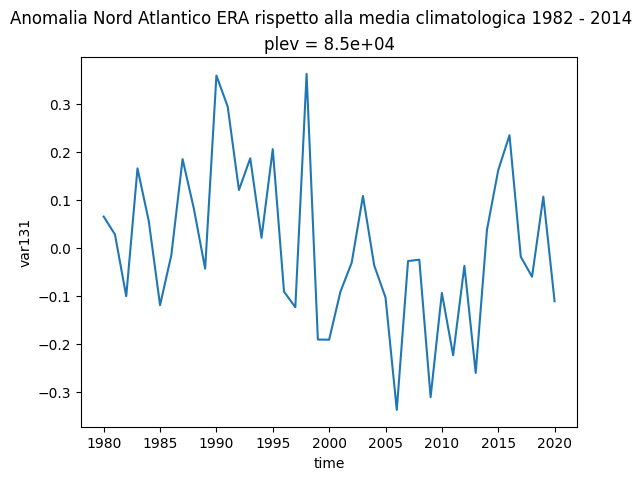

In [10]:
#ERA5 box Nord Atlantico
dataset_ERA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_remap.nc').sel(lon=slice(280,360), lat=slice(20,80)) #seleziono lon lat del Nord Atlantico
#dataset pesato
dataset_ERA_weighted_na = compute_dataset_weighted(dataset_ERA_na["var131"])
#media annuale Nord Atlantico
annual_mean_era_na = compute_annual_mean_weighted(dataset_ERA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
era_na_1982_2014 = dataset_ERA_na.sel(time=slice("1982-01", "2014-12"))
#peso il dataset del periodo scelto
era_na_1982_2014_weighted = compute_dataset_weighted(era_na_1982_2014["var131"])
#calcolo la media annuale sul periodo scelto
annual_mean_era_na_30 = compute_annual_mean_weighted(era_na_1982_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_era = compute_anomaly(annual_mean_era_na,annual_mean_era_na_30)
#plot
anomaly_era.plot()
plt.suptitle('Anomalia Nord Atlantico ERA rispetto alla media climatologica 1982 - 2014')

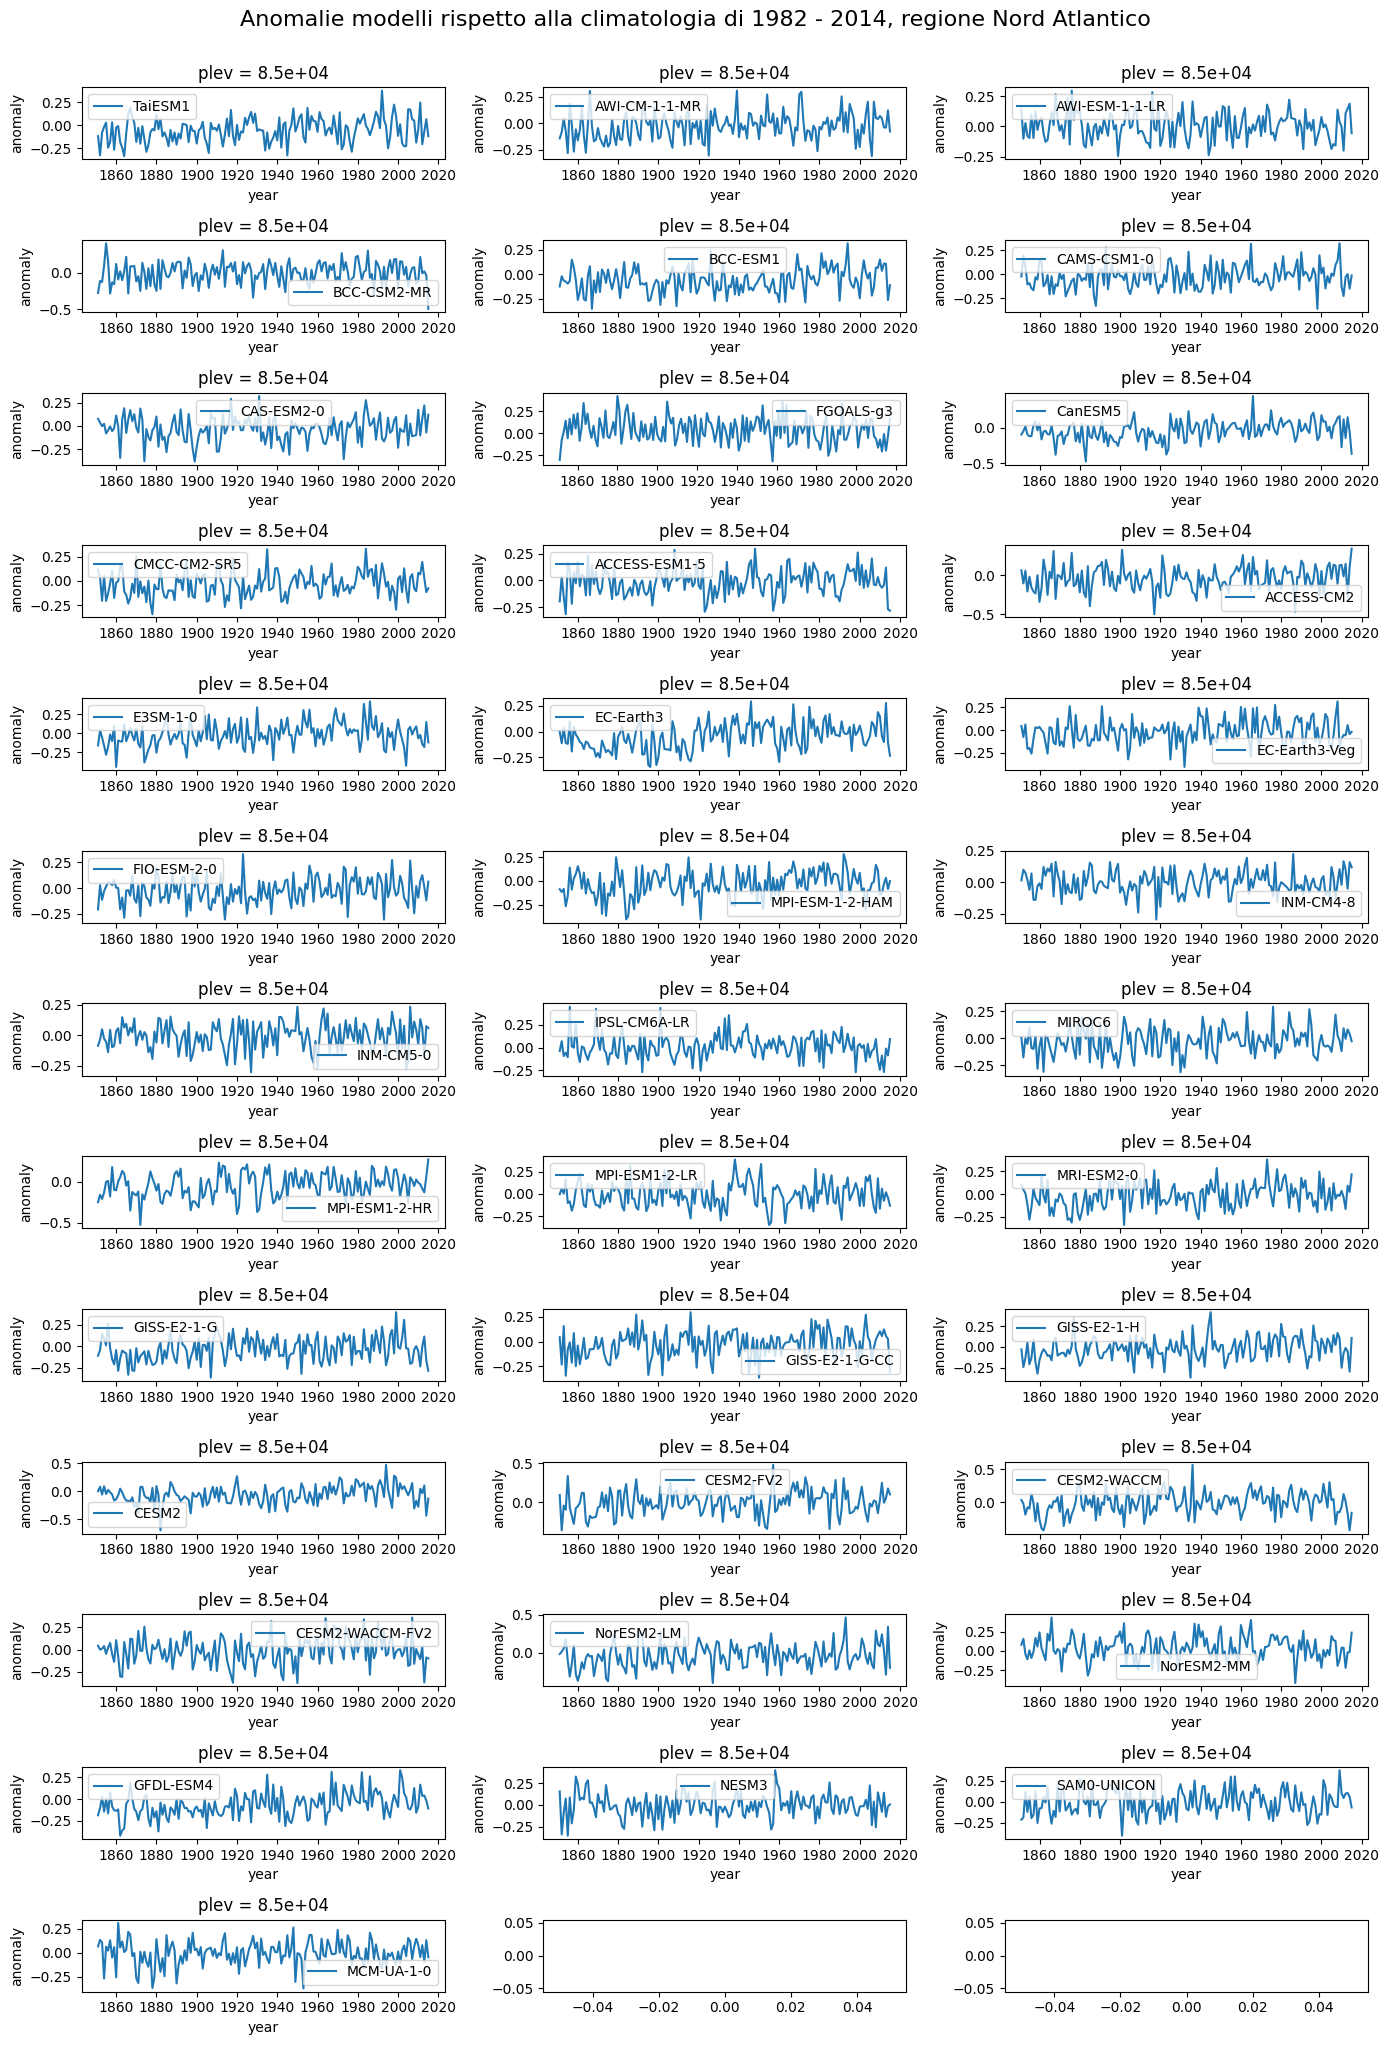

In [11]:
#Plot delle anomalie dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_atmos)/3)+1),ncols=3,figsize=(14,20))

for i in range((int(len(models_atmos)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos):
            break
        model_name = models_list_atmos[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic anomaly'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('anomaly')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Anomalie modelli rispetto alla climatologia di 1982 - 2014, regione Nord Atlantico', fontsize=16, y=1.02)

plt.savefig('atmos_anomalies.pdf', format='pdf')

Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1982 - 2014

Dataset ERA5

In [12]:
#Dataset ERA5
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_na_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_na_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_na["var131"],"1982","2014",i)
era_na_seas_mean.keys()

dict_keys([1, 2, 3, 4])

Modelli

In [13]:
for name in models_atmos.keys():
    # Seleziono il box Nord Atlantico
    na_box = models_atmos[name]['atmos North Atlantic box']    
    for i in range(4): # Ciclo su tutte le stagioni
        # Calcolo la media temporale per ogni stagione dei modelli MAM, JJA, SON, DJF
        # Calcolo il bias modelli - dataset
        if (i+1) == 1: # MAM
            models_atmos[name]['atmos North Atlantic seasonal mean MAM'] = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
            model_na_seas_mean = models_atmos[name]['atmos North Atlantic seasonal mean MAM']
            model_na_seas_mean = model_na_seas_mean.assign_coords({"plev" : model_na_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_atmos[name]['atmos North Atlantic bias MAM'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 2 : # JJA
            models_atmos[name]['atmos North Atlantic seasonal mean JJA'] = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
            model_na_seas_mean = models_atmos[name]['atmos North Atlantic seasonal mean JJA']
            model_na_seas_mean = model_na_seas_mean.assign_coords({"plev" : model_na_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_atmos[name]['atmos North Atlantic bias JJA'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 3 : # SON
            models_atmos[name]['atmos North Atlantic seasonal mean SON'] = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
            model_na_seas_mean = models_atmos[name]['atmos North Atlantic seasonal mean SON']
            model_na_seas_mean = model_na_seas_mean.assign_coords({"plev" : model_na_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_atmos[name]['atmos North Atlantic bias SON'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 4 : # DJF
            models_atmos[name]['atmos North Atlantic seasonal mean DJF'] = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
            model_na_seas_mean = models_atmos[name]['atmos North Atlantic seasonal mean DJF']
            model_na_seas_mean = model_na_seas_mean.assign_coords({"plev" : model_na_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_atmos[name]['atmos North Atlantic bias DJF'] = model_na_seas_mean - era_na_seas_mean[i+1]

In [14]:
#Conto quanti modelli hanno (0,30,40)
num_models = 0 #Inizializzo il conteggio
for name in models_atmos.keys():
    if models_atmos[name]['atmos North Atlantic bias DJF'].shape == (0,30,40):
        num_models = num_models + 1
        print("Il modello che ha shape (0,30,40) è: ", name)
print(num_models)

0


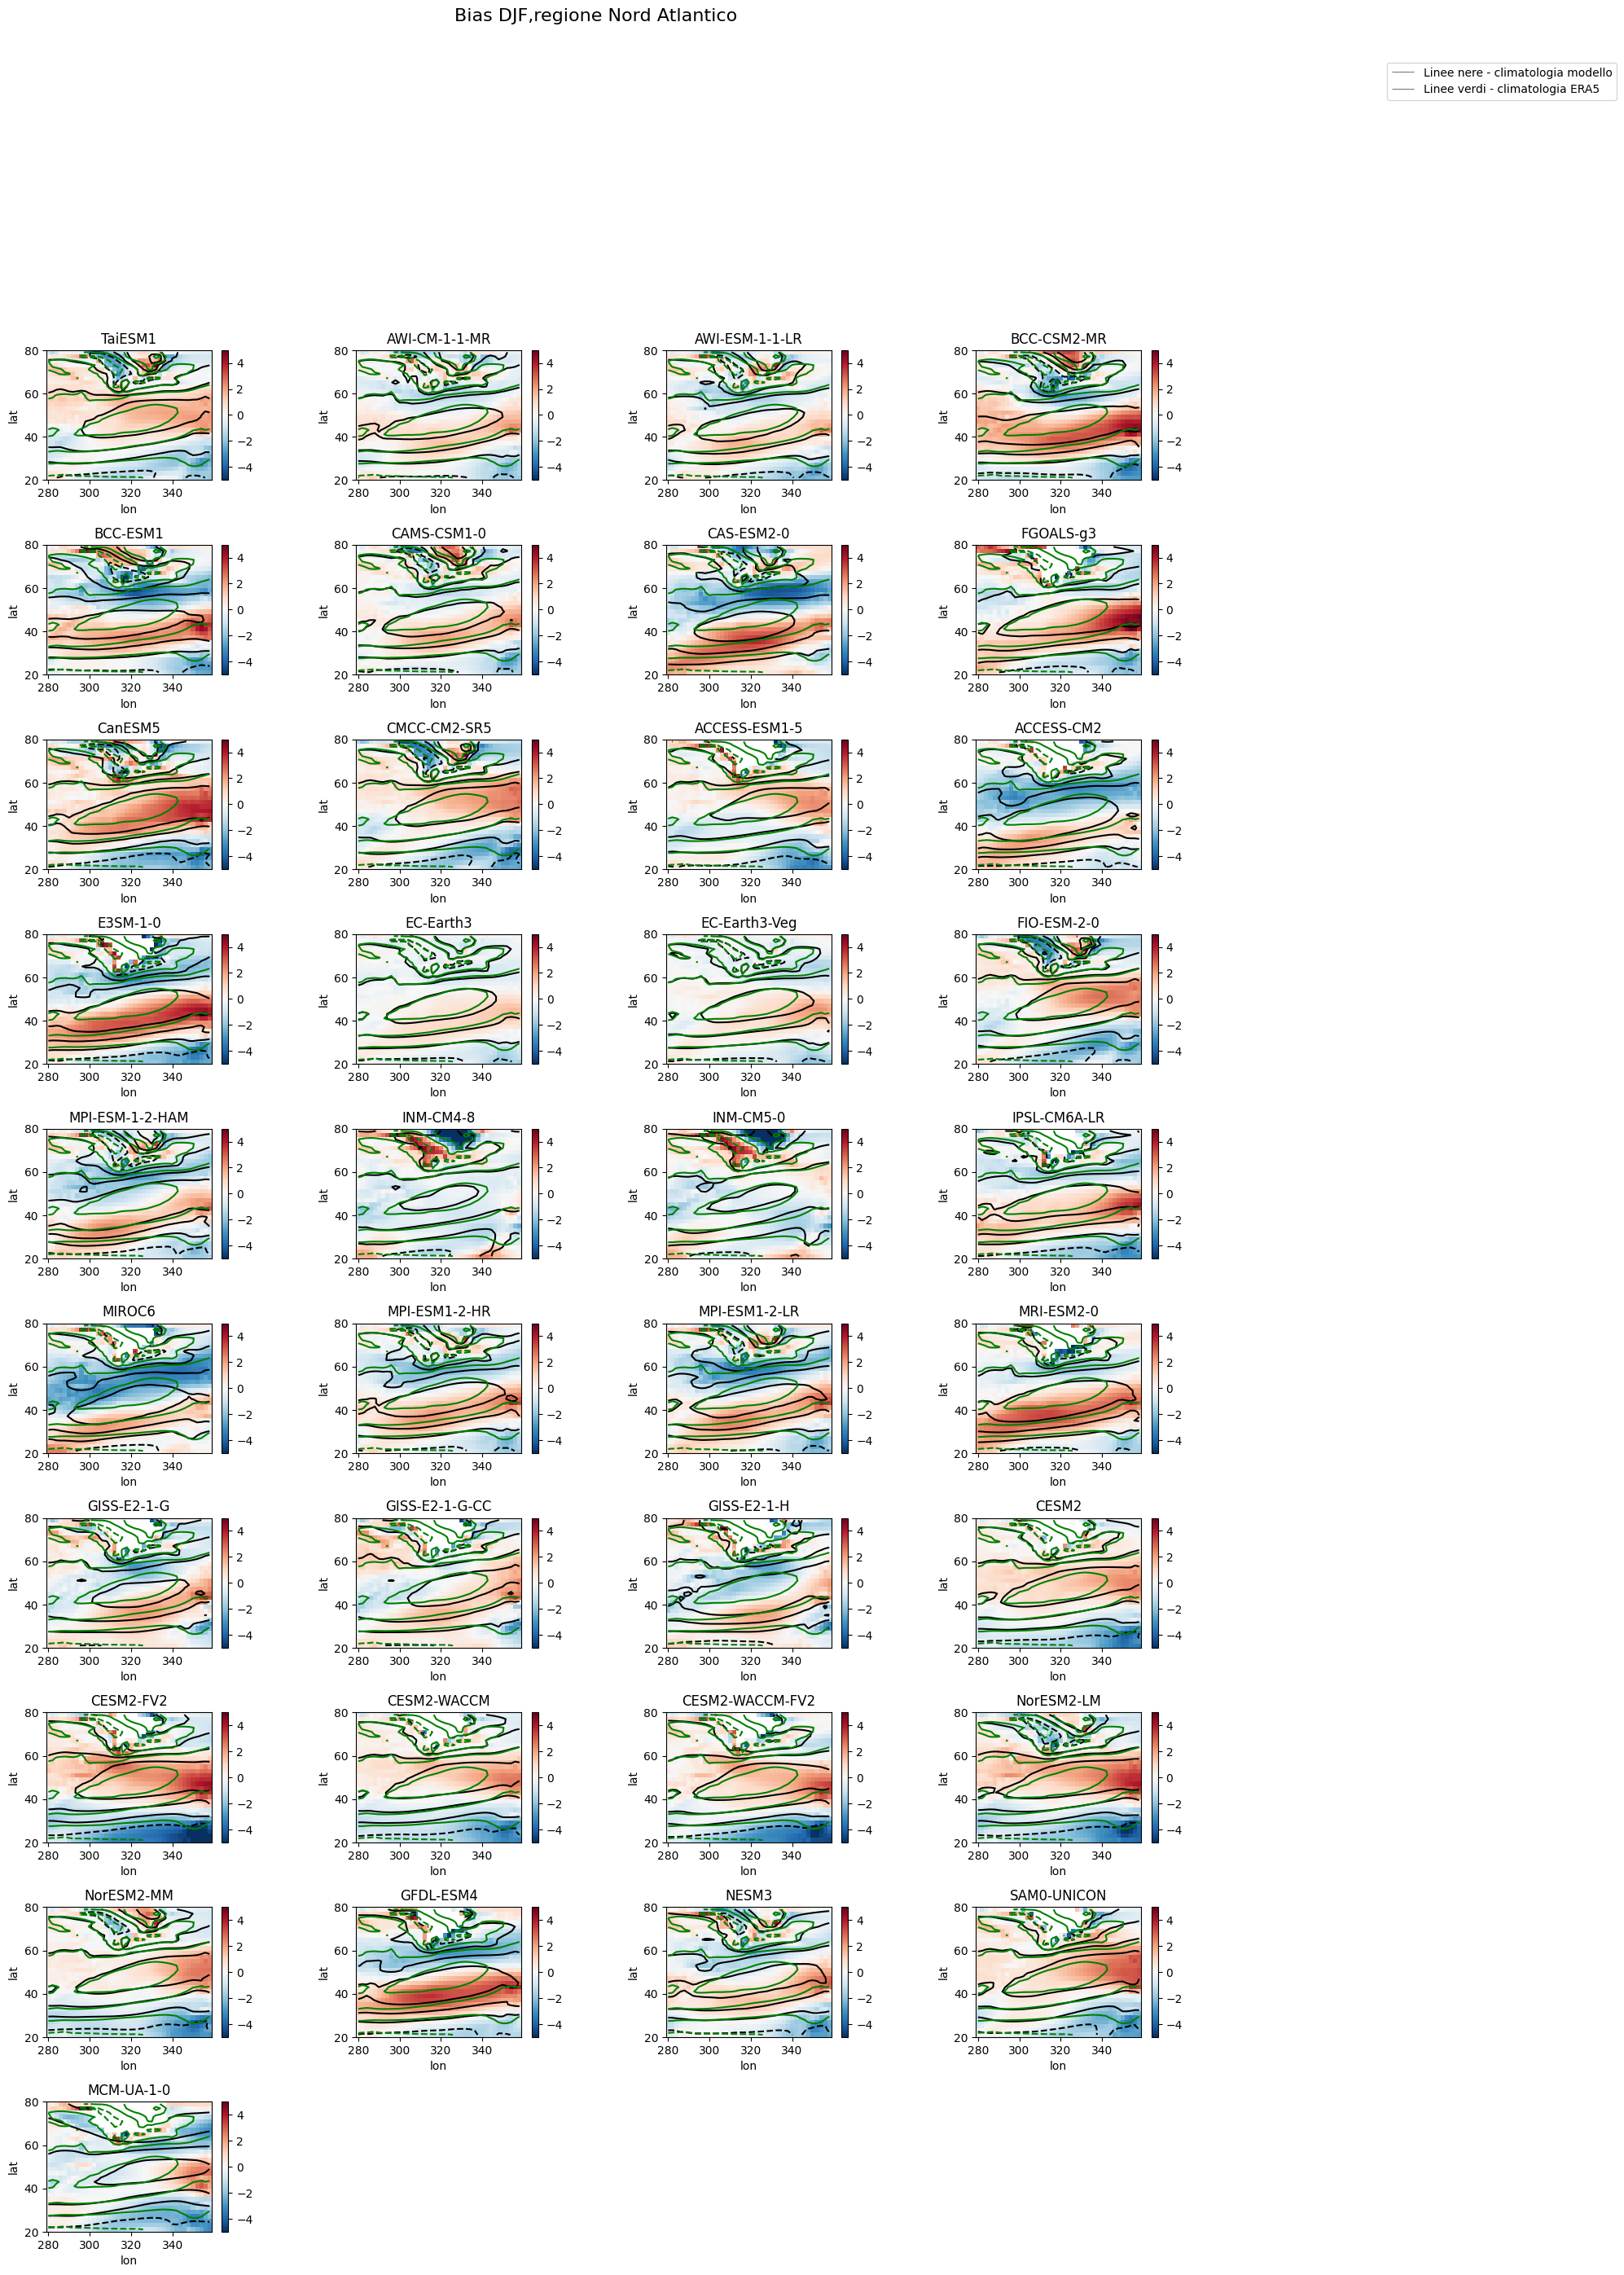

In [15]:
plot_bias_atmos((int(len(models_atmos)/4)+1),4,(18,30),-5,5,models_list_atmos,models_atmos,era_na_seas_mean,'Bias DJF,regione Nord Atlantico','atmos_bias_djf.pdf')

In [16]:
list_cluster0 = list_cluster0_pca
list_cluster1 = list_cluster1_pca
list_cluster2 = list_cluster2_pca
list_cluster3 = list_cluster3_pca
list_cluster4 = list_cluster4_pca

In [17]:
print(list_cluster0)
print(list_cluster1)
print(list_cluster2)
print(list_cluster3)
print(list_cluster4)

['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']
['INM-CM4-8', 'INM-CM5-0']


Plot dei modelli nei 5 cluster di tos

Cluster 0

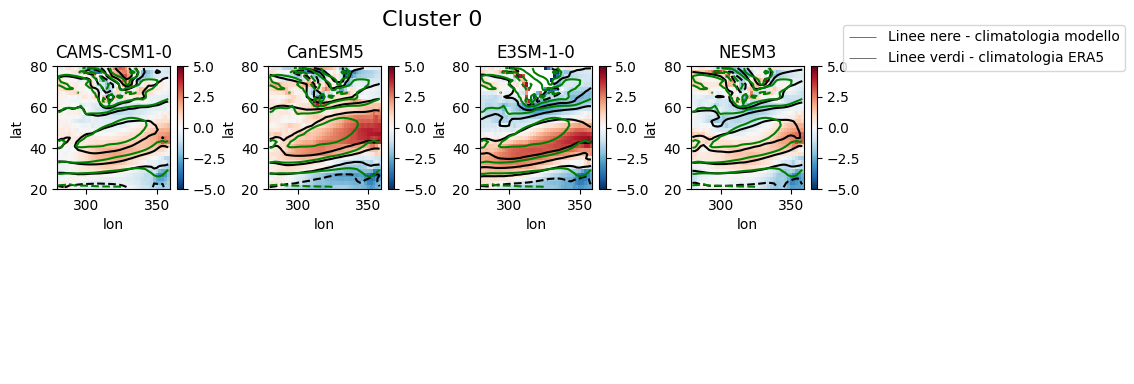

In [18]:
#cluster 0 ['TaiESM1', 'CMCC-CM2-SR5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
#plot del cluster 0 con climatologia dei modelli e di ERA5
plot_cluster_0_ua = plot_bias_atmos((int(len(list_cluster0)/4)+1),4,(10,4),-5,5,list_cluster0,models_atmos,era_na_seas_mean,'Cluster 0','atmos_cluster0.pdf')

Cluster 0 medio

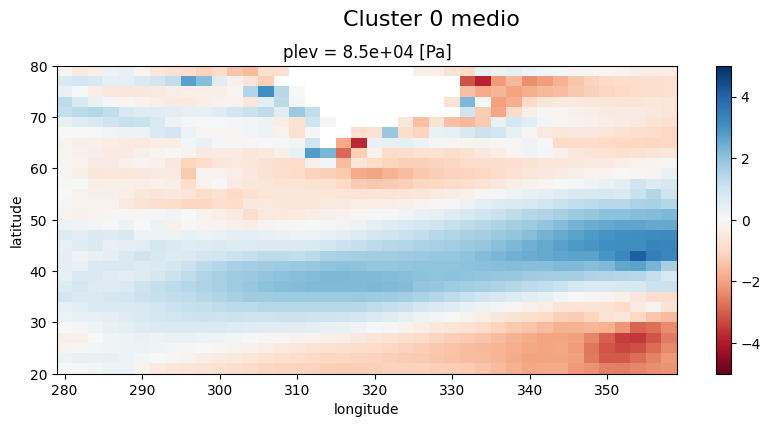

In [19]:
#plot dei cluster medi
plot_cluster_0_mean = plot_mean_cluster_atmos(list_cluster0,models_atmos,'Cluster 0 medio','atmos_cluster0_mean.pdf',-5,5,(10,4))

Cluster 0 standard deviation

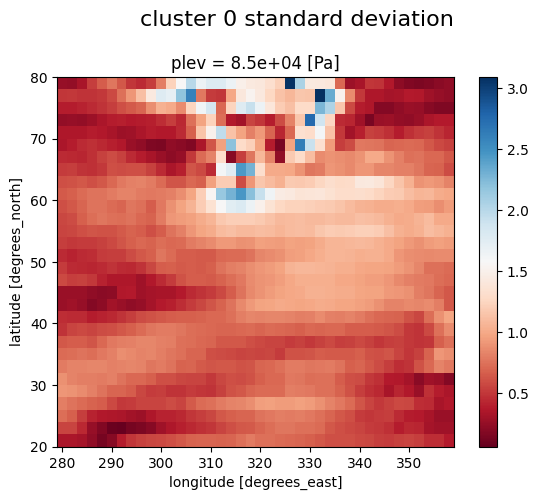

In [20]:
plot_std_cluster_atmos(list_cluster0,models_atmos,'cluster 0 standard deviation','atmos_cluster0_std.pdf')

Cluster 1

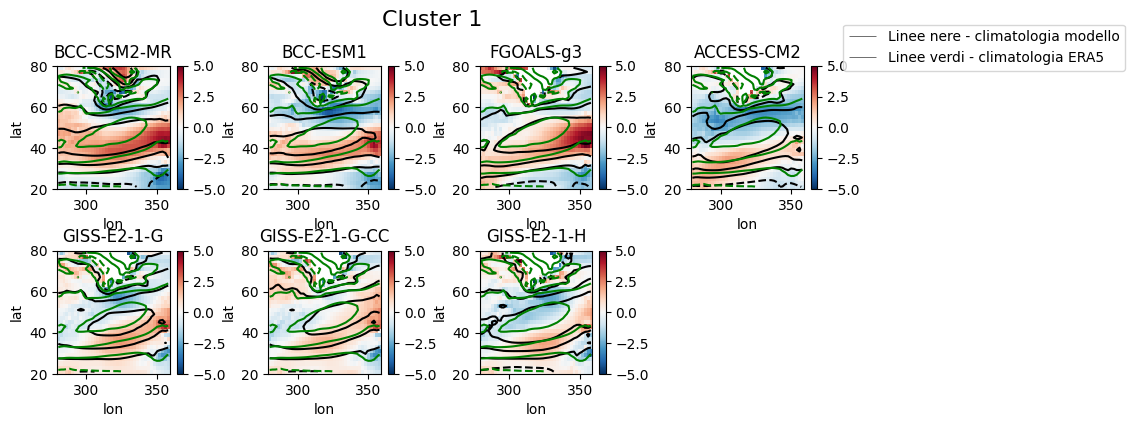

In [21]:
#cluster 1 ['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'NorCPM1']
#plot del cluster 1 con climatologia dei modelli e di ERA5
plot_cluster_1_ua = plot_bias_atmos((int(len(list_cluster1)/4)+1),4,(10,4),-5,5,list_cluster1,models_atmos,era_na_seas_mean,'Cluster 1','atmos_cluster1.pdf')

Cluster 1 medio

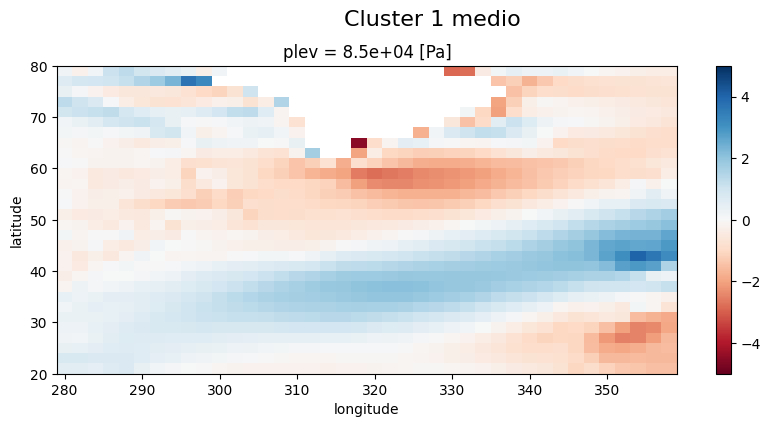

In [22]:
#plot dei cluster medi
plot_cluster_1_mean = plot_mean_cluster_atmos(list_cluster1,models_atmos,'Cluster 1 medio','atmos_cluster1_mean.pdf',-5,5,(10,4))

Cluster 1 standard deviation

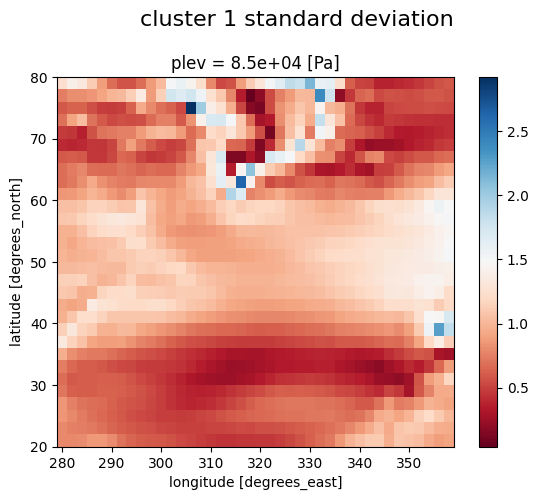

In [23]:
plot_std_cluster_atmos(list_cluster1,models_atmos,'cluster 1 standard deviation','atmos_cluster1_std.pdf')

Cluster 2

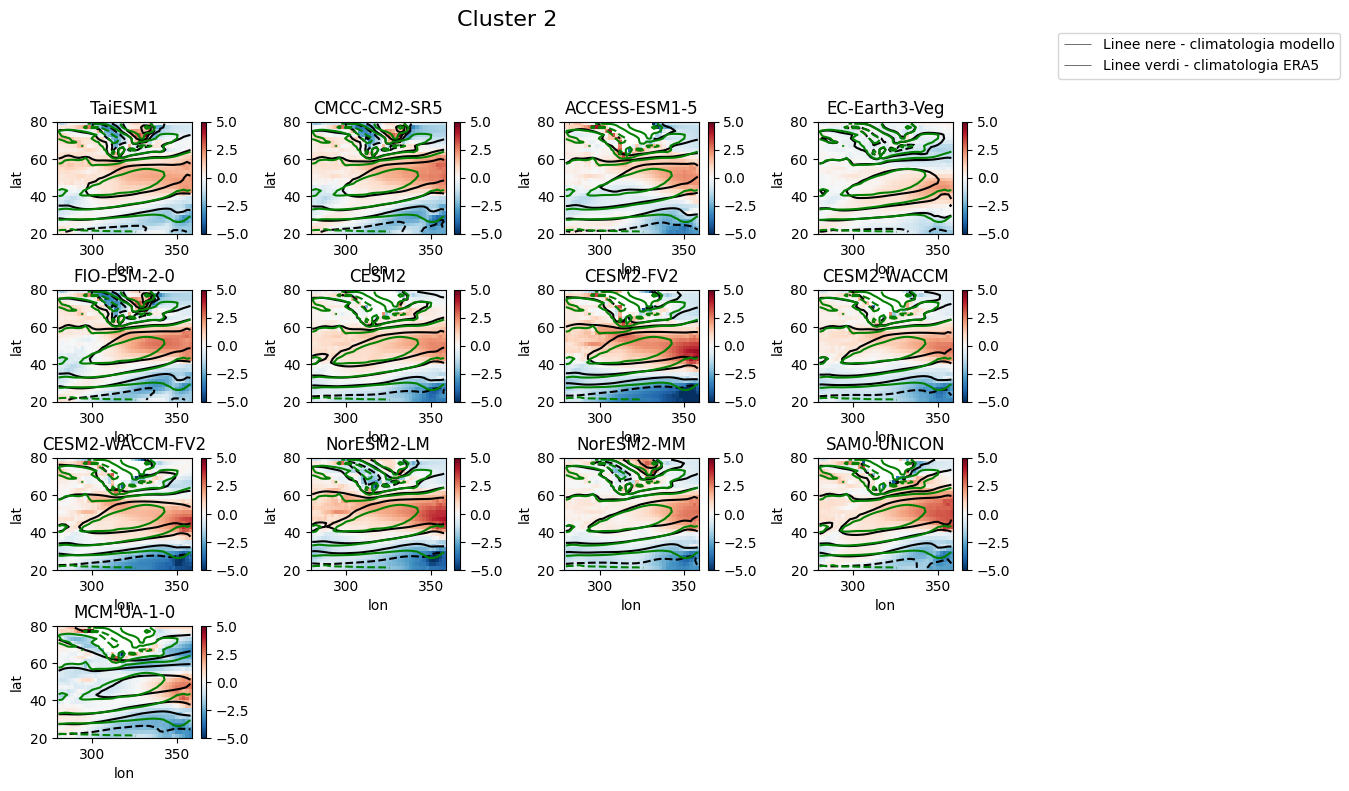

In [24]:
#cluster 2 ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4']#
#plot del cluster 2 con climatologia dei modelli e di ERA5
plot_cluster_2_ua = plot_bias_atmos((int(len(list_cluster2)/4)+1),4,(12,8),-5,5,list_cluster2,models_atmos,era_na_seas_mean,'Cluster 2','atmos_cluster2.pdf')

Cluster 2 medio

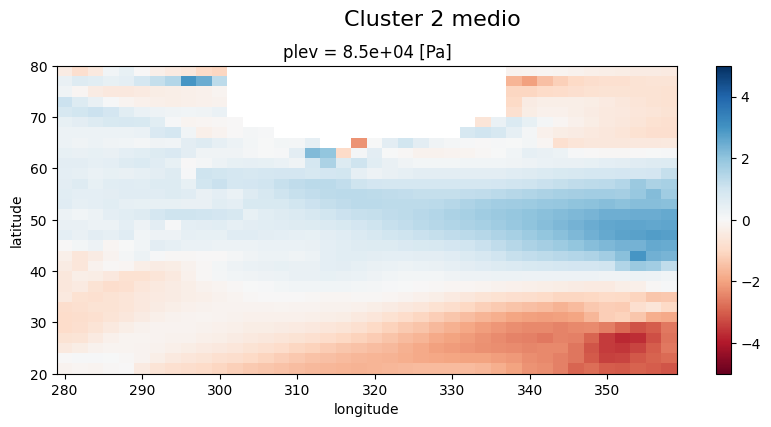

In [25]:
#plot dei cluster medi
plot_cluster_2_mean = plot_mean_cluster_atmos(list_cluster2,models_atmos,'Cluster 2 medio','atmos_cluster2_mean.pdf',-5,5,(10,4))

Cluster 2 standard deviation

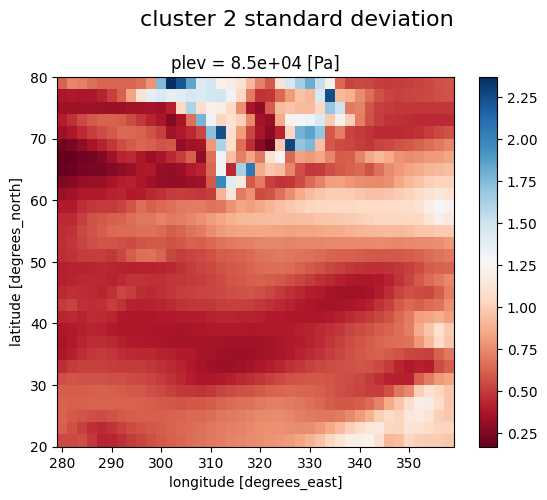

In [26]:
plot_std_cluster_atmos(list_cluster2,models_atmos,'cluster 2 standard deviation','atmos_cluster2_std.pdf')

Cluster 3

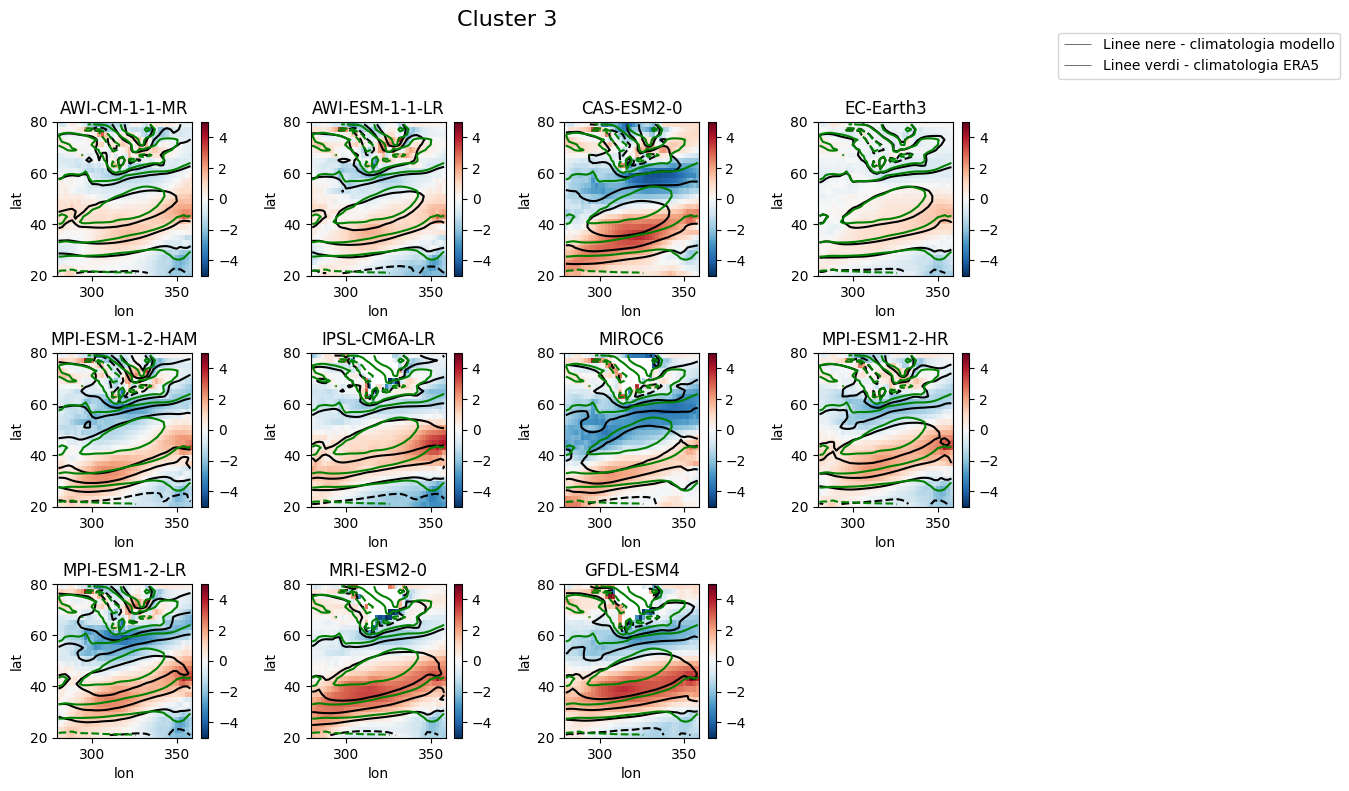

In [27]:
plot_cluster_3_ua = plot_bias_atmos((int(len(list_cluster3)/4)+1),4,(12,8),-5,5,list_cluster3,models_atmos,era_na_seas_mean,'Cluster 3','atmos_cluster3.pdf')

Cluster 3 medio

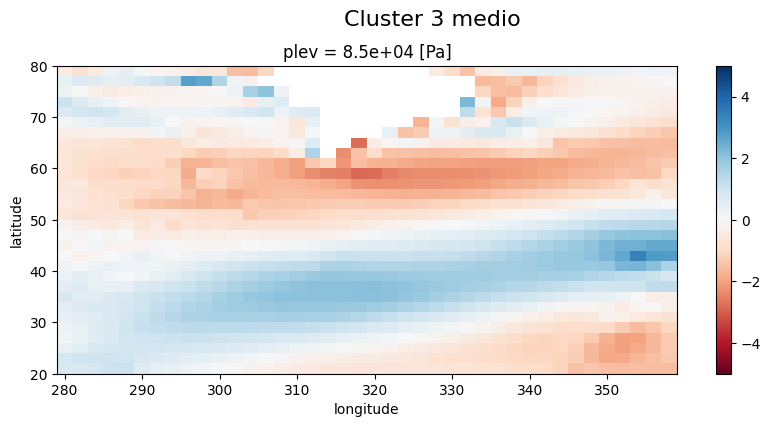

In [28]:
#plot dei cluster medi
plot_cluster_3_mean = plot_mean_cluster_atmos(list_cluster3,models_atmos,'Cluster 3 medio','atmos_cluster3_mean.pdf',-5,5,(10,4))

Cluster 3 standard deviation

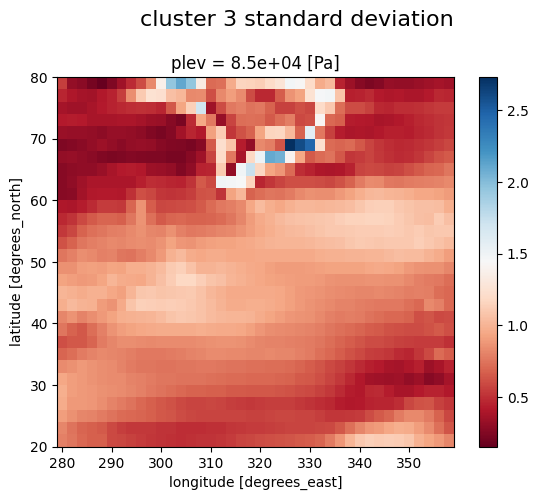

In [29]:
plot_std_cluster_atmos(list_cluster3,models_atmos,'cluster 3 standard deviation','atmos_cluster3_std.pdf')

Cluster 4

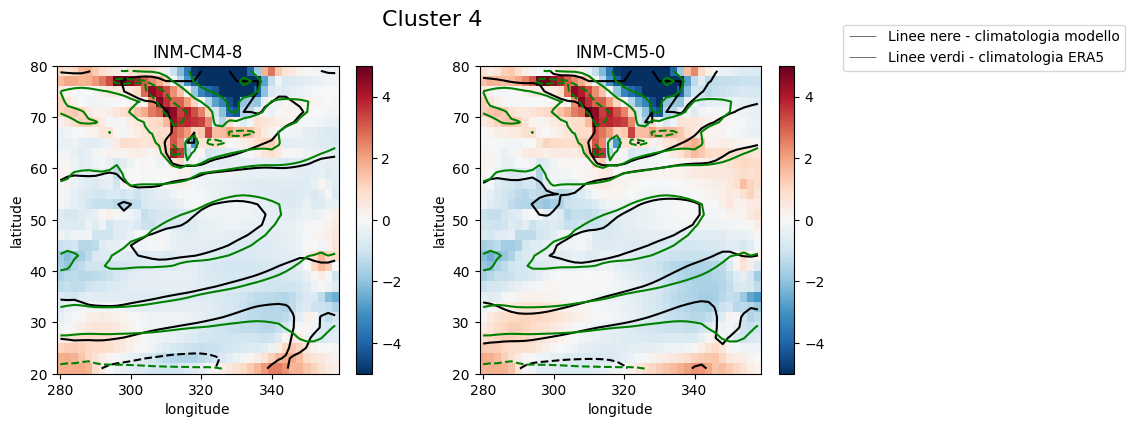

In [30]:
#cluster 4 ['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
#plot del cluster 4 con climatologia dei modelli e di ERA5
plot_cluster_4_ua = plot_bias_2_models_atmos((10,4),-5,5,list_cluster4,models_atmos,era_na_seas_mean,'Cluster 4','atmos_cluster4.pdf')

Cluster 4 medio

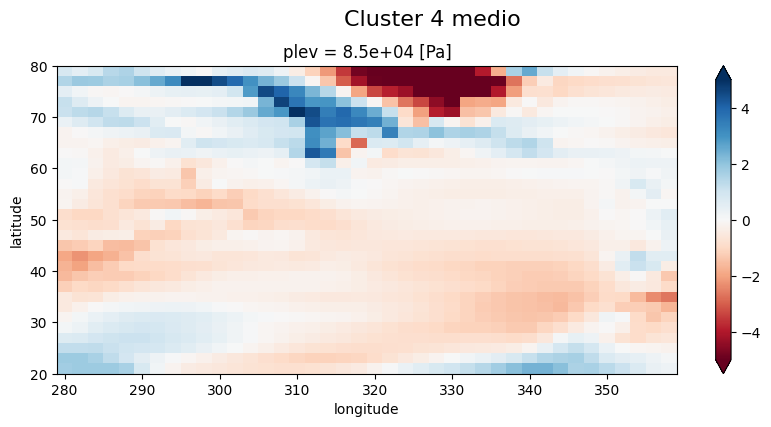

In [31]:
#plot dei cluster medi
plot_cluster_4_mean = plot_mean_cluster_atmos(list_cluster4,models_atmos,'Cluster 4 medio','atmos_cluster4_mean.pdf',-5,5,(10,4))

Cluster 4 standard deviation

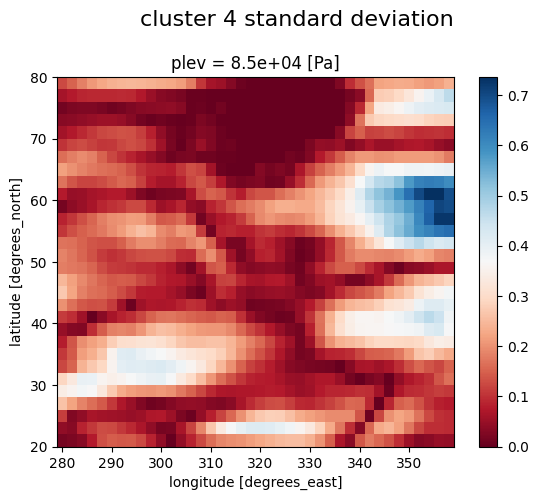

In [32]:
plot_std_cluster_atmos(list_cluster4,models_atmos,'cluster 4 standard deviation','atmos_cluster4_std.pdf')

Salvo in file pickle

In [33]:
# Salvataggio di models_atmos
with open('models_atmos.pkl', 'wb') as file:
    dill.dump(models_atmos, file)
    dill.dump(era_na_seas_mean,file)
# Salvataggio liste e immagini pdf in un file Pickle
with open('modelli_atmos.pickle', 'wb') as f: #'wb' = write binary
    pickle.dump(list_cluster0, f) #salvataggio lista con nomi cluster
    pickle.dump(list_cluster1, f)
    pickle.dump(list_cluster2, f)
    pickle.dump(list_cluster3, f)
    pickle.dump(list_cluster4, f)
    pickle.dump(['atmos_cluster0.pdf'], f) #salvataggio immagini modelli per ogni cluster
    pickle.dump(['atmos_cluster1.pdf'], f)
    pickle.dump(['atmos_cluster2.pdf'], f)
    pickle.dump(['atmos_cluster3.pdf'], f)
    pickle.dump(['atmos_cluster4.pdf'], f)    
    pickle.dump(['atmos_cluster0_mean.pdf'], f) #salvataggio immagini cluster medio
    pickle.dump(['atmos_cluster1_mean.pdf'], f)    
    pickle.dump(['atmos_cluster2_mean.pdf'], f)    
    pickle.dump(['atmos_cluster3_mean.pdf'], f)    
    pickle.dump(['atmos_cluster4_mean.pdf'], f)   
    pickle.dump(['atmos_cluster0_std.pdf'], f) #salvataggio immagini cluster standard deviation
    pickle.dump(['atmos_cluster1_std.pdf'], f)    
    pickle.dump(['atmos_cluster2_std.pdf'], f)    
    pickle.dump(['atmos_cluster3_std.pdf'], f)    
    pickle.dump(['atmos_cluster4_std.pdf'], f)